# Unit15_Appendix | Fuel Gas Emission：以 DNN 預測 NOx 排放（回歸）

本 Notebook 使用 `Part_4/data/fuel_gas/train.csv` 建立回歸型 DNN（MLP）模型來預測 `NOX`。

## 目標
- 建立 baseline（Ridge）與 DNN 的效果對照
- 示範正確資料切分與標準化（避免 data leakage）
- 以 MAE / RMSE / R2 評估模型
- 產生 `test.csv` 的推論結果並保存模型

資料背景可參考 Kaggle：https://www.kaggle.com/datasets/sjagkoo7/fuel-gas-emission/data


In [1]:
from __future__ import annotations

from pathlib import Path
import json
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

# TensorFlow/Keras（可選）：若環境未安裝，Notebook 仍可用 sklearn 的 MLPRegressor 完成 DNN（MLP）回歸
TF_AVAILABLE = False
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    TF_AVAILABLE = True
except Exception:
    tf = None
    keras = None
    layers = None

# 讓結果可重現
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
if TF_AVAILABLE:
    tf.random.set_seed(SEED)

# 路徑設定：此 Notebook 預期在 Part_4 目錄下執行
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data" / "fuel_gas"
OUTPUT_DIR = NOTEBOOK_DIR / "outputs" / "P4_Unit15_Appendix_FuelGasEmission"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

FIG_DIR = OUTPUT_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"


def savefig(name: str) -> Path:
    path = FIG_DIR / f"{name}.png"
    plt.savefig(path, dpi=160, bbox_inches="tight")
    print("Saved fig:", path)
    return path


print("Notebook dir:", NOTEBOOK_DIR)
print("Train path:", TRAIN_PATH)
print("Test  path:", TEST_PATH)
print("Output dir:", OUTPUT_DIR)
print("Backend:", "tensorflow/keras" if TF_AVAILABLE else "sklearn-mlp")
if TF_AVAILABLE:
    print("TensorFlow:", tf.__version__)


Notebook dir: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4
Train path: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\fuel_gas\train.csv
Test  path: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\fuel_gas\test.csv
Output dir: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission
Backend: sklearn-mlp


## 1) 讀取資料與快速檢查

- `train.csv`：包含 10 個特徵欄位 + 目標 `NOX`
- `test.csv`：只包含 10 個特徵欄位（用於推論示範）


In [2]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

print("train:", df.shape)
print("test :", df_test.shape)
display(df.head())

print("\nMissing values (train):")
display(df.isna().sum())

print("\nTarget (NOX) summary:")
display(df["NOX"].describe())


train: (5187, 11)
test : (2224, 10)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,12.728,1007.8,87.949,4.4928,24.333,1086.3,550.02,134.41,11.838,0.95374,74.117
1,24.577,1011.4,47.300,2.9115,18.739,1051.0,549.94,104.80,10.141,2.54190,61.887
2,14.084,1017.6,73.675,2.9318,19.350,1057.5,550.03,112.21,10.535,3.90110,75.568
3,32.422,1011.0,52.727,4.5852,29.825,1099.6,540.82,146.50,13.279,0.35179,52.580
4,13.788,1016.8,86.933,3.5058,24.090,1085.8,550.03,133.33,11.775,1.73960,69.873



Missing values (train):


AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64


Target (NOX) summary:


count    5187.000000
mean       67.655454
std        10.767665
min        27.765000
25%        60.371000
50%        65.704000
75%        74.445500
max       119.320000
Name: NOX, dtype: float64

## 2) EDA：相關性（簡易）

只做快速檢查：觀察 `NOX` 與各特徵的線性相關係數，幫助建立直覺（不代表因果）。


NOX     1.000000
CO      0.398577
AP      0.397132
AH      0.204171
TAT     0.081853
AFDP   -0.029571
TEY    -0.121759
CDP    -0.194726
TIT    -0.227484
GTEP   -0.244853
AT     -0.652353
Name: NOX, dtype: float64

Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\figs\corr_bar.png


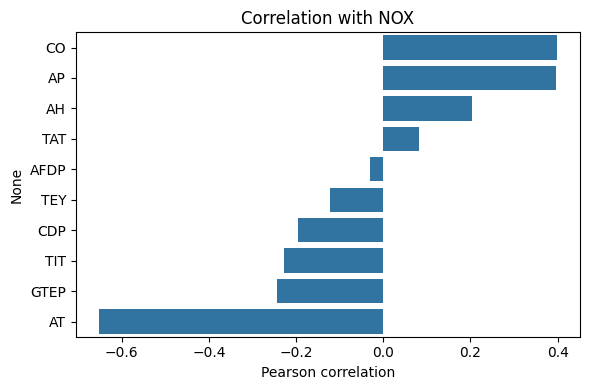

In [3]:
corr = df.corr(numeric_only=True)["NOX"].sort_values(ascending=False)
display(corr)

plt.figure(figsize=(6, 4))
sns.barplot(x=corr.drop("NOX").values, y=corr.drop("NOX").index, orient="h")
plt.title("Correlation with NOX")
plt.xlabel("Pearson correlation")
plt.tight_layout()
savefig("corr_bar")
plt.show()


## 3) 資料切分與標準化（避免 Data Leakage）

流程：
1. 從 `train.csv` 分離 `X` 與 `y`（`NOX`）
2. 切分成 train/valid/test
3. `StandardScaler` 僅使用訓練集 `fit`，再對 valid/test 做 `transform`


In [4]:
target_col = "NOX"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].to_numpy(dtype=np.float32)
y = df[target_col].to_numpy(dtype=np.float32)

# train : valid : test = 70% : 15% : 15%
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=SEED
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEED
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s = scaler.transform(X_test)

print("X_train:", X_train_s.shape)
print("X_valid:", X_valid_s.shape)
print("X_test :", X_test_s.shape)


X_train: (3630, 10)
X_valid: (778, 10)
X_test : (779, 10)


## 4) Baseline：Ridge Regression

建立一個快速 baseline，作為 DNN 是否值得的比較基準。


In [5]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)
pred_ridge = ridge.predict(X_test_s)

mae_r = float(mean_absolute_error(y_test, pred_ridge))
rmse_r = float(np.sqrt(mean_squared_error(y_test, pred_ridge)))
r2_r = float(r2_score(y_test, pred_ridge))

print(f"Ridge  MAE : {mae_r:.3f}")
print(f"Ridge RMSE : {rmse_r:.3f}")
print(f"Ridge R2  : {r2_r:.3f}")


Ridge  MAE : 3.622
Ridge RMSE : 5.620
Ridge R2  : 0.714


## 5) DNN（MLP）回歸模型

重點：
- 多層 Dense（全連接）
- BatchNorm + Dropout 增加訓練穩定度、降低過擬合
- EarlyStopping / ReduceLROnPlateau 協助收斂


In [6]:
def build_model(input_dim: int):
    if TF_AVAILABLE:
        model = keras.Sequential(
            [
                layers.Input(shape=(input_dim,)),
                layers.Dense(128, activation="relu"),
                #layers.BatchNormalization(),
                #layers.Dropout(0.20),
                layers.Dense(64, activation="relu"),
                #layers.BatchNormalization(),
                #layers.Dropout(0.20),
                layers.Dense(32, activation="relu"),
                layers.Dense(1),
            ]
        )
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="mse",
            metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
        )
        return model

    return MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=64,
        learning_rate_init=1e-3,
        max_iter=1,          # 搭配 warm_start 逐 epoch 訓練
        warm_start=True,
        shuffle=True,
        random_state=SEED,
    )


model = build_model(input_dim=X_train_s.shape[1])
if TF_AVAILABLE:
    model.summary()
else:
    print(model)


MLPRegressor(batch_size=64, hidden_layer_sizes=(128, 64, 32), max_iter=1,
             random_state=42, warm_start=True)


In [7]:
if TF_AVAILABLE:
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=30, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", patience=10, factor=0.5, min_lr=1e-6
        ),
    ]

    history = model.fit(
        X_train_s,
        y_train,
        validation_data=(X_valid_s, y_valid),
        epochs=500,
        batch_size=64,
        callbacks=callbacks,
        verbose=1,
    )
else:
    # sklearn MLPRegressor：用 warm_start + max_iter=1 自己做 epoch loop
    train_losses = []
    val_losses = []

    best_val = float("inf")
    best_state = None
    patience = 30
    wait = 0
    max_epochs = 500

    for epoch in range(1, max_epochs + 1):
        model.fit(X_train_s, y_train)

        pred_train = model.predict(X_train_s)
        pred_valid = model.predict(X_valid_s)

        train_loss = float(mean_squared_error(y_train, pred_train))
        val_loss = float(mean_squared_error(y_valid, pred_valid))

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch == 1 or epoch % 25 == 0:
            print(f"epoch={epoch:4d} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            wait = 0
            best_state = ([w.copy() for w in model.coefs_], [b.copy() for b in model.intercepts_])
        else:
            wait += 1

        if wait >= patience:
            print(f"Early stopping at epoch={epoch}, best val_loss={best_val:.4f}")
            break

    if best_state is not None:
        model.coefs_, model.intercepts_ = best_state

    history = {"loss": train_losses, "val_loss": val_losses}


epoch=   1 train_loss=2715.6538 val_loss=2716.3840
epoch=  25 train_loss=15.8060 val_loss=15.9657
epoch=  50 train_loss=14.0684 val_loss=15.7234
epoch=  75 train_loss=12.6052 val_loss=15.5036
epoch= 100 train_loss=11.4875 val_loss=15.2311
epoch= 125 train_loss=10.7784 val_loss=15.3974
Early stopping at epoch=132, best val_loss=15.2304


Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\figs\loss_curve.png


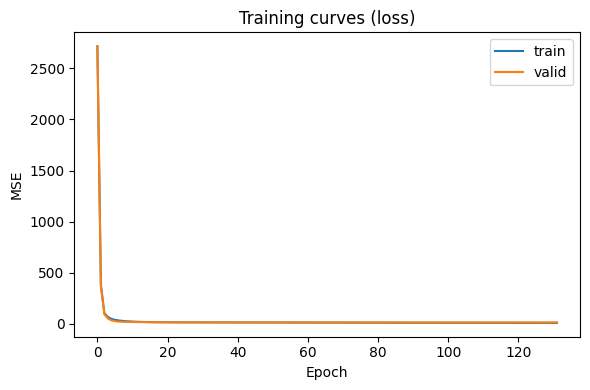

In [8]:
if TF_AVAILABLE:
    hist = pd.DataFrame(history.history)
else:
    hist = pd.DataFrame(history)

plt.figure(figsize=(6, 4))
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="valid")
plt.title("Training curves (loss)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
savefig("loss_curve")
plt.show()


## 6) 評估：MAE / RMSE / R2 + Parity plot


In [9]:
if TF_AVAILABLE:
    pred_dnn = model.predict(X_test_s, verbose=0).reshape(-1)
else:
    pred_dnn = model.predict(X_test_s).reshape(-1)

mae = float(mean_absolute_error(y_test, pred_dnn))
rmse = float(np.sqrt(mean_squared_error(y_test, pred_dnn)))
r2 = float(r2_score(y_test, pred_dnn))

print(f"DNN   MAE : {mae:.3f}")
print(f"DNN  RMSE : {rmse:.3f}")
print(f"DNN   R2  : {r2:.3f}")

print()
print("(比較) Ridge baseline")
print(f"Ridge MAE : {mae_r:.3f}")
print(f"Ridge RMSE: {rmse_r:.3f}")
print(f"Ridge R2  : {r2_r:.3f}")

metrics = {
    "backend": "tensorflow/keras" if TF_AVAILABLE else "sklearn-mlp",
    "n_train": int(X_train_s.shape[0]),
    "n_valid": int(X_valid_s.shape[0]),
    "n_test": int(X_test_s.shape[0]),
    "ridge": {"mae": float(mae_r), "rmse": float(rmse_r), "r2": float(r2_r)},
    "dnn": {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)},
}

metrics_path = OUTPUT_DIR / "metrics.json"
metrics_path.write_text(json.dumps(metrics, ensure_ascii=False, indent=2), encoding="utf-8")
print()
print("Saved metrics:", metrics_path)


DNN   MAE : 2.454
DNN  RMSE : 3.560
DNN   R2  : 0.885

(比較) Ridge baseline
Ridge MAE : 3.622
Ridge RMSE: 5.620
Ridge R2  : 0.714

Saved metrics: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\metrics.json


Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\figs\parity_plot.png


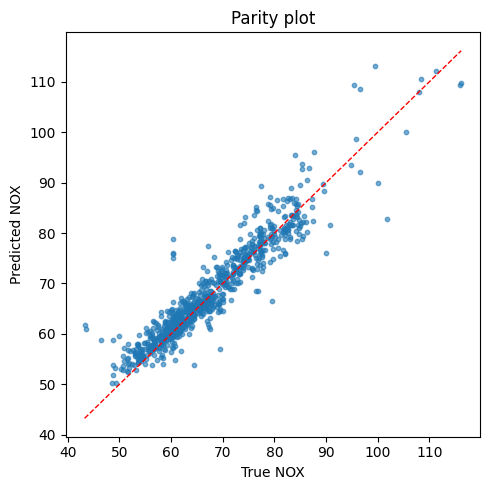

Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\figs\residual_plot.png


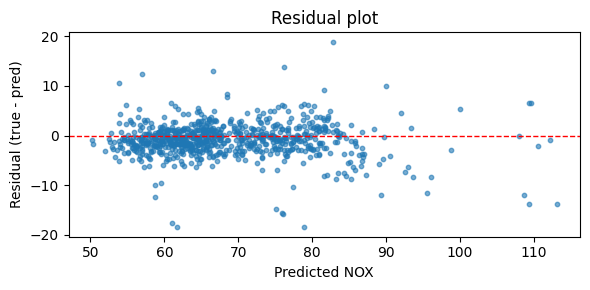

In [10]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, pred_dnn, s=10, alpha=0.6)

min_v = float(min(y_test.min(), pred_dnn.min()))
max_v = float(max(y_test.max(), pred_dnn.max()))
plt.plot([min_v, max_v], [min_v, max_v], "r--", linewidth=1)

plt.xlabel("True NOX")
plt.ylabel("Predicted NOX")
plt.title("Parity plot")
plt.tight_layout()
savefig("parity_plot")
plt.show()

residual = y_test - pred_dnn
plt.figure(figsize=(6, 3))
plt.scatter(pred_dnn, residual, s=10, alpha=0.6)
plt.axhline(0, color="r", linestyle="--", linewidth=1)
plt.xlabel("Predicted NOX")
plt.ylabel("Residual (true - pred)")
plt.title("Residual plot")
plt.tight_layout()
savefig("residual_plot")
plt.show()


## 7) 保存模型與推論 `test.csv`

- 保存：`outputs/P4_Unit15_Appendix_FuelGasEmission/models/`
- 產生 `test.csv` 的 NOX 預測：`outputs/P4_Unit15_Appendix_FuelGasEmission/nox_predictions_test.csv`


In [11]:
MODEL_DIR = OUTPUT_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

if TF_AVAILABLE:
    model_path = MODEL_DIR / "nox_dnn.keras"
    model.save(model_path)
else:
    model_path = MODEL_DIR / "nox_dnn_mlp.joblib"
    joblib.dump(model, model_path)

print("Saved model:", model_path)

scaler_path = MODEL_DIR / "scaler.joblib"
joblib.dump(scaler, scaler_path)
print("Saved scaler:", scaler_path)

X_kaggle = df_test[feature_cols].to_numpy(dtype=np.float32)
X_kaggle_s = scaler.transform(X_kaggle)

if TF_AVAILABLE:
    pred_kaggle = model.predict(X_kaggle_s, verbose=0).reshape(-1)
else:
    pred_kaggle = model.predict(X_kaggle_s).reshape(-1)

pred_path = OUTPUT_DIR / "nox_predictions_test.csv"
pd.DataFrame({"NOX": pred_kaggle}).to_csv(pred_path, index=False)
print("Saved predictions:", pred_path)

display(pd.read_csv(pred_path).head())


Saved model: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\models\nox_dnn_mlp.joblib
Saved scaler: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\models\scaler.joblib
Saved predictions: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\nox_predictions_test.csv


,NOX
0,52.932583
1,71.185585
2,69.219444
3,81.840310
4,76.803474


## 8) test.csv（推論）

test.csv 不含目標欄位 NOX，需使用訓練好的模型與 scaler 產生 NOX 預測，並將結果儲存於 outputs/.../nox_predictions_test.csv。預測結果會合併至原始 test 特徵（欄位如 NOX_pred）以便後續分析與視覺化。

- test.csv：10 個特徵欄位（與 train 相同），不包含 NOX  
- 流程：載入 scaler -> 對 test 特徵做 transform -> 使用模型 predict -> 儲存預測結果  
- 建議檢查：train NOX 與 test 預測 NOX 的分布比較；NOX_pred 與關鍵特徵（例如 AT、CO）之散佈圖


Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\figs\test_pred_vs_train_dist.png


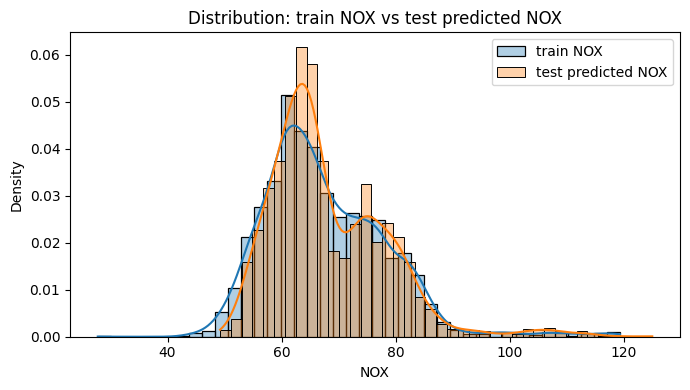

Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_FuelGasEmission\figs\test_pred_scatter.png


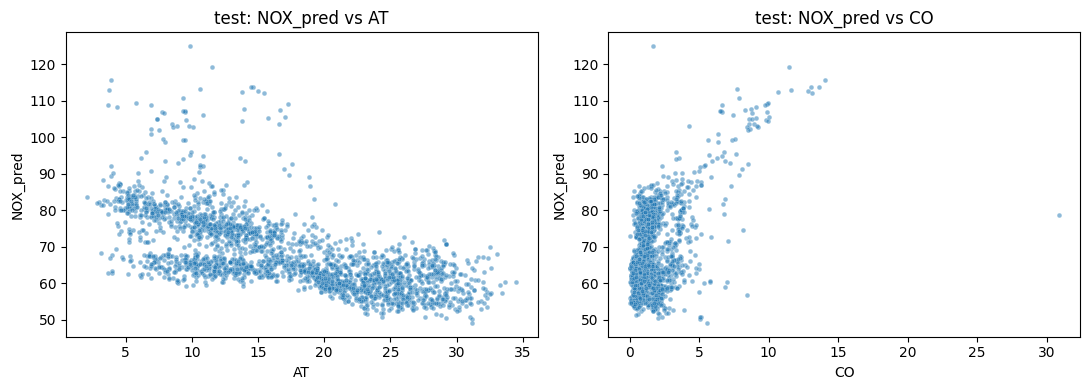

In [12]:
# 讀取預測結果
pred_df = pd.read_csv(pred_path)

plt.figure(figsize=(7, 4))
sns.histplot(df["NOX"], bins=40, stat="density", kde=True, color="C0", label="train NOX", alpha=0.35)
sns.histplot(pred_df["NOX"], bins=40, stat="density", kde=True, color="C1", label="test predicted NOX", alpha=0.35)
plt.title("Distribution: train NOX vs test predicted NOX")
plt.xlabel("NOX")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
savefig("test_pred_vs_train_dist")
plt.show()

# 將 test 特徵與預測值合併，便於視覺化
viz_df = df_test.copy()
viz_df["NOX_pred"] = pred_df["NOX"].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
sns.scatterplot(data=viz_df, x="AT", y="NOX_pred", s=12, alpha=0.5, ax=axes[0])
axes[0].set_title("test: NOX_pred vs AT")
axes[0].set_xlabel("AT")
axes[0].set_ylabel("NOX_pred")

sns.scatterplot(data=viz_df, x="CO", y="NOX_pred", s=12, alpha=0.5, ax=axes[1])
axes[1].set_title("test: NOX_pred vs CO")
axes[1].set_xlabel("CO")
axes[1].set_ylabel("NOX_pred")

plt.tight_layout()
savefig("test_pred_scatter")
plt.show()
